# Generic pipeline for segmentation tests

This notebook demonstrates how a pretrained model can be used to perform semantic segmentation on a set of images and compute some statistics on the identified objects. The model used below is the pretrained [`Mask2FormerForUniversalSegmentation`](https://huggingface.co/docs/transformers/en/model_doc/mask2former) model from Huggingface, which is an implementation of the [`Mask2Former`](https://arxiv.org/abs/2112.01527) model from FAIR.

In [1]:
# --------------------------------------
import warnings

warnings.filterwarnings("ignore")

# --------------------------------------
from copy import deepcopy

# --------------------------------------
from PIL import Image

# --------------------------------------
from rich import print as pp

# --------------------------------------
import numpy as np

# --------------------------------------
import matplotlib.pyplot as plt

# --------------------------------------
import streetscapes as scs

## Load a segmentation model

In this example, we instruct the model that all instances of `sky` and `water` should be treated as a single instance.

In [2]:
model = scs.models.MaskFormer()

Select a few images at random.

<span style="color:red;">Note</span>: please make sure that you download some images first (cf. `download_city_images.ipynb`).

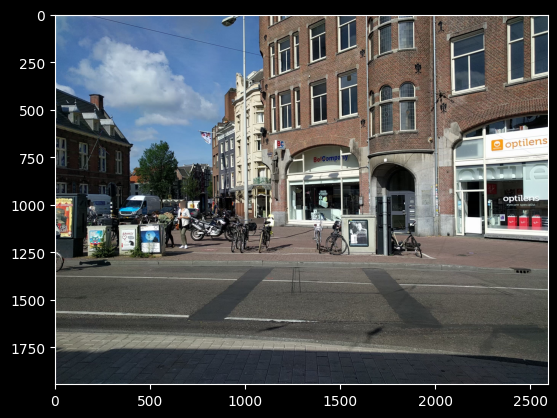

In [3]:
image_dir = scs.conf.OUTPUT_DIR / "images"
test_image = list(np.random.choice(list(image_dir.glob("*.jpeg")), 1, replace=False))[0]
img_data = np.array(Image.open(test_image))
plt.imshow(img_data)

Define some categories of objects that we would like to extract. It is possible to define categories hierarchically so that categories deeper in the hierarchy would be 'subtracted' from their parents ones. For instance, this can be used to instruct the model to extract 'building' objects _without_ 'window' or 'door' objects. This example is used below.

In [4]:
labels = {
    "sky": None,
    "building": {
        "window": None,
        "door": None,
    },
    "tree": None,
    "car": None,
    "truck": None,
    "road": None,
}

## Segment the images

In [5]:
metadata = model.segment({test_image.name: img_data}, labels)

Streetscapes | 2025-02-18@17:07:08 | Segmenting images...
Streetscapes | 2025-02-18@17:07:08 | Detecting objects...
Streetscapes | 2025-02-18@17:07:15 | Computing statistics...


100%|██████████| 25/25 [00:01<00:00, 17.45it/s]

Streetscapes | 2025-02-18@17:07:18 | [ 5439813.jpeg ] Extracted 25 instances for 15 labels.


Show the segmentation result for our test image.

In [6]:
meta = deepcopy(metadata[0])

In [7]:
meta

{'masks': array([[ 4,  4,  4, ...,  1,  1,  1],
        [ 4,  4,  4, ...,  1,  1,  1],
        [ 4,  4,  4, ...,  1,  1,  1],
        ...,
        [21, 21, 21, ..., 21, 21, 21],
        [21, 21, 21, ..., 21, 21, 21],
        [21, 21, 21, ..., 21, 21, 21]], shape=(1944, 2592), dtype=int32),
 'outlines': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(1944, 2592), dtype=int32),
 'stats': {'instance': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25],
  'label': ['building',
   'bicycle',
   'curb',
   'sky',
   'billboard',
   'bicycle',
   'bicyclist',
   'pole',
   'car',
   'billboard',
   'lane-marking-general',
   'bicycle',
   'sidewalk',
   'billboard',
   'junction-box',
   'bicycle',
   'car',
   'ca

### Visualise the the segmentation results

In [8]:
instance_labels = set(meta['stats']["label"])

Select a few categories that we might be interested in.

In [9]:
focus = {"building", "sky"}

Display the segmentation results.

In [10]:
meta

{'masks': array([[ 4,  4,  4, ...,  1,  1,  1],
        [ 4,  4,  4, ...,  1,  1,  1],
        [ 4,  4,  4, ...,  1,  1,  1],
        ...,
        [21, 21, 21, ..., 21, 21, 21],
        [21, 21, 21, ..., 21, 21, 21],
        [21, 21, 21, ..., 21, 21, 21]], shape=(1944, 2592), dtype=int32),
 'outlines': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], shape=(1944, 2592), dtype=int32),
 'stats': {'instance': [1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25],
  'label': ['building',
   'bicycle',
   'curb',
   'sky',
   'billboard',
   'bicycle',
   'bicyclist',
   'pole',
   'car',
   'billboard',
   'lane-marking-general',
   'bicycle',
   'sidewalk',
   'billboard',
   'junction-box',
   'bicycle',
   'car',
   'ca

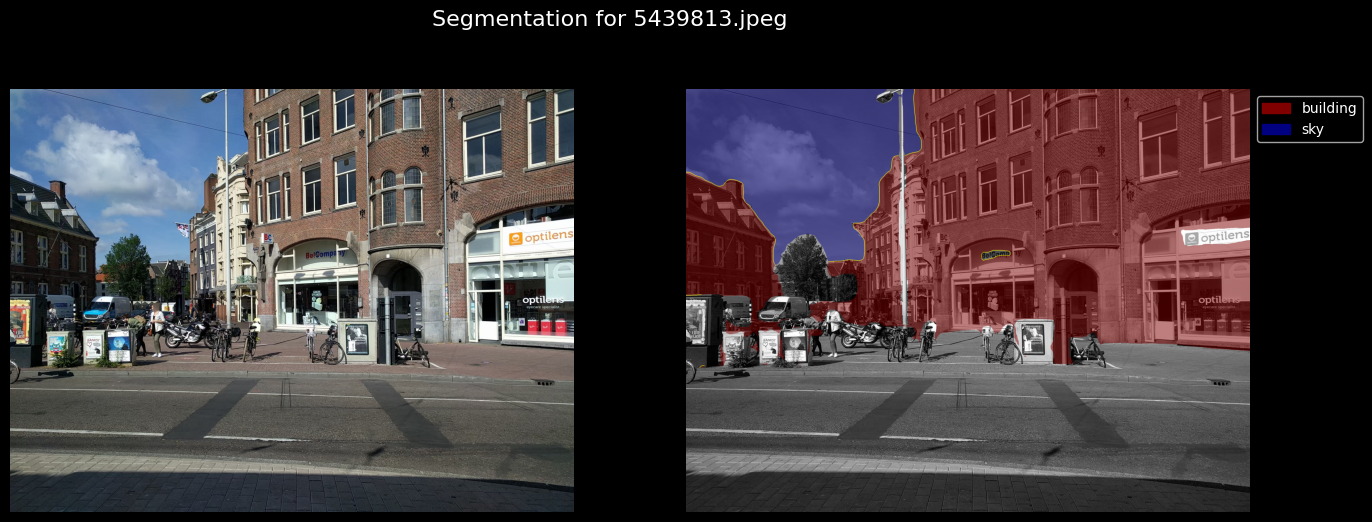

In [11]:
(fig, ax) = model.visualise_segmentation(img_data, meta, focus, title=test_image.name, outline="#ffff00")

## Process images from a subset

The segmentation model also provides a convenience method to process all the images in a subset of the `streetscapes` dataset.

Load a subset file.

In [12]:
amsterdam_side = scs.conf.OUTPUT_DIR / "amsterdam_side.csv"

Select a file to save the statistics to.

In [13]:
out_file_path = amsterdam_side.with_name(f"{amsterdam_side.stem}.parquet")

Process all images in the dataset.

In [39]:
(paths, metadata) = model.segment_from_dataset(amsterdam_side, labels, sample=1)

Streetscapes | 2025-02-18@17:15:41 | Segmenting images...
Streetscapes | 2025-02-18@17:15:41 | Detecting objects...
Streetscapes | 2025-02-18@17:15:44 | Computing statistics...


100%|██████████| 15/15 [00:00<00:00, 24.55it/s]

Streetscapes | 2025-02-18@17:15:45 | [ 810616479901226.jpeg ] Extracted 15 instances for 9 labels.


Get the path and the metadata for the first image.

In [40]:
path = paths[0]
meta = metadata[0]

In [43]:
np.array(meta["masks"])

array([[ 2,  2,  2, ..., 12, 12, 12],
       [ 2,  2,  2, ..., 12, 12, 12],
       [ 2,  2,  2, ..., 12, 12, 12],
       ...,
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6],
       [ 6,  6,  6, ...,  6,  6,  6]], shape=(1536, 2048))

In [27]:
path, path.exists()

(PosixPath('/home/hobbes/code/github/streetscapes/remote/local/output/images/4903613679720258.jpeg'),
 True)

Save the metadata to a Parquet file using the image name as the base.

In [28]:
# metadata_path = model.save_metadata(meta, path.with_suffix(".parquet"))
metadata_path = path.with_suffix(".parquet")

The statistics can be loaded back into a dictionary format from the Parquet file.

In [29]:
# loaded_stats = model.load_stats(out_file_path)
loaded_stats = model.load_metadata(metadata_path)

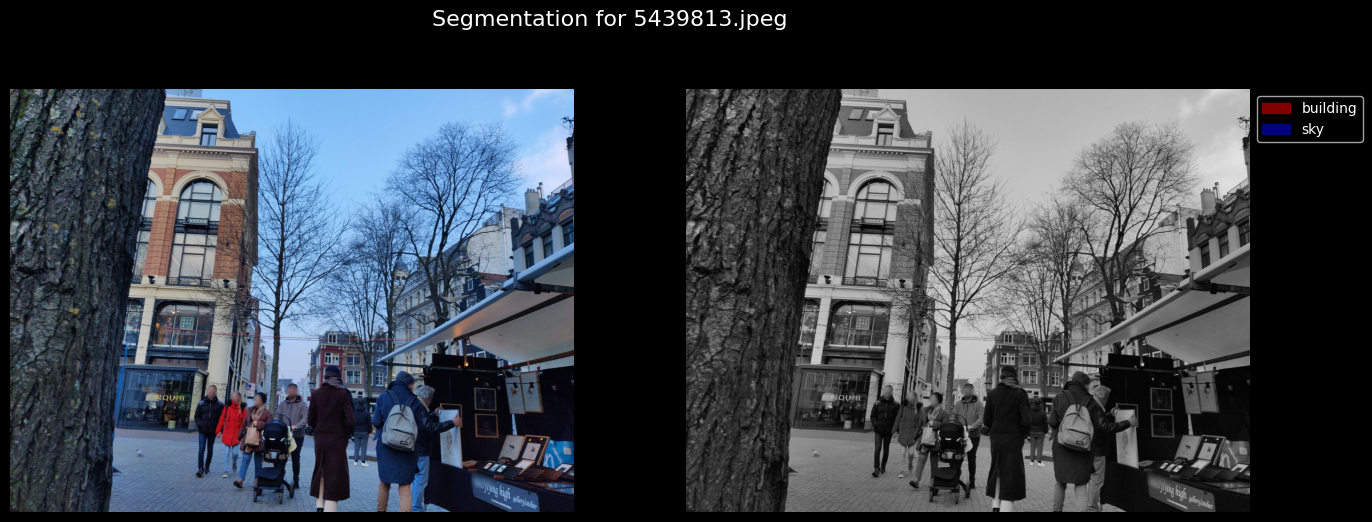

In [32]:
img_data = np.array(Image.open(paths[0]))
(fig, ax) = model.visualise_segmentation(
    img_data, meta, focus, title=test_image.name, outline="#ffff00"
)

In [ ]:
plt.imshow(loaded_stats['outlines'], cmap="grey")

Pick an image file and check that the computed statistics and the loaded statistics are identical

In [16]:
test_image = list(ds_images.keys())[0]

A sample item from the computed statistics

In [ ]:
pp(ds_stats[test_image]['building'])

The same item from the loaded statistics

In [ ]:
pp(loaded_stats[test_image]["building"])

## Compute the statistics

The result is a dictionary of statistics for each segment of each category type.